#### imports

In [1]:
import pandas as pd 
from moonlight import *
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import geopy.distance
plt.rcParams["figure.figsize"] = (15,10)

#### load dataset
you need to download the _Melbourne Bike Share Station Readings 2011-2017_ dataset from [here](https://data.melbourne.vic.gov.au/Transport/Melbourne-Bike-Share-Station-Readings-2011-2017/74id-aqj9)

In [2]:
#data_path = "path_to_dataset"
data_path = "./examples/bike/Melbourne_Bike_Share_Station_Readings_2011-2017.csv"
df = pd.read_csv(data_path)

#### get data from 22 Aprile 2017

In [3]:
df_day = df[df['RUNDATE'].apply(lambda date: str(date).startswith('20170422'))]

#### add column ABSOLUTETIME representing the time in seconds starting from 00:00

In [4]:
def total_seconds(int_date):
    date = str(int_date)
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:8])
    hour = int(date[8:10])
    minutes = int(date[10:12])
    seconds = int(date[12:])
    delta = datetime(year, month, day, hour, minutes, seconds) - datetime(year, month, day, 0, 0, 0)
    return delta.total_seconds()

df_day['ABSOLUTETIME']=df_day['RUNDATE'].apply(lambda date: total_seconds(date))

/home/ssilvetti/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [5]:
import math

class Location:
    def __init__(self,index ,name, coordinates, trace):
        self.index = index
        self.name = name
        self.coordinates = coordinates
        self.trace=trace
        
    def distance(self, other):
        left = self.coordinates
        right = other.coordinates
        return geopy.distance.distance(left, right).m
    
    def get_trace_values(self):
        return [[value[1]] for value in self.trace]
    
    def get_trace_time(self):
        return [value[0] for value in self.trace]
    
    def __str__(self):
        return f"[{self.index},{self.coordinates}]"

        
class LocationDatabase:
    def __init__(self):
        self.db = list()
        
    @staticmethod
    def get_location_full(df, name, index):
        location = df[df['NAME'] == name]
        row = location.iloc[0]
        coordinates = row['LAT'],row['LONG']
        traces = location.apply(lambda row: (row['ABSOLUTETIME'], row['NBBIKES']), axis = 1 )
        values = list(traces.values)
        values.sort(key=lambda x: x[0])
        return Location(index,name,coordinates,values)
    
    def generate_from_df(self,df):
        location_names = df_day['NAME'].unique()
        n = 0
        for name in location_names:
            self.db.append(self.get_location_full(df, name, n))
            n=n+1
    
    def get_graph(self):
        graph = []
        for l_idx in range(len(self.db)):
            for r_idx in range(len(self.db)):
                left_location = self.db[l_idx]
                right_location = self.db[r_idx]
                graph.append([left_location.index,right_location.index, left_location.distance(right_location)])
        return [graph]
    
    def get_traces(self):
        return [location.get_trace_values() for location in self.db ]
    
    def get_time(self):
        return self.db[0].get_trace_time()
    
    def show_locations_map(self):
        coordinates = [location.coordinates for location in self.db]
        lat = [x[0] for x in coordinates]
        long = [x[1] for x in coordinates]
        print("lat",min(lat),max(lat))
        print("long",min(long),max(long))
        plt.scatter(lat, long)
        plt.show()
        
        

    def __str__(self):
        return str([str(location) for location in self.db])

lat -37.867067999999996 -37.79625
long 144.935296 144.988507


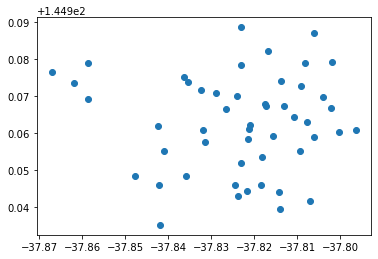

In [6]:
locationDb = LocationDatabase()
locationDb.generate_from_df(df_day)
locationDb.show_locations_map()

In [8]:
script = """
signal { int nBikes; }
space {edges { real distance; }}
domain boolean;
formula service = globally{( nBikes==0 ) reach(distance) [0, 500] ( nBikes>0 )};
"""
moonlightScript = ScriptLoader.loadFromText(script)
booleanMonitor = moonlightScript.getMonitor("service")
timeGraph = [0.0]
graph = locationDb.get_graph()
timeSignalValues = locationDb.get_time()
signalValues = locationDb.get_traces()
booleanMonitorResult = booleanMonitor.monitor(timeGraph,graph,timeSignalValues,signalValues)
print(booleanMonitorResult)

[[[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, -1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0], [75605.0, 1.0], [85510.0, 1.0]], [[5.0, 1.0], [61205.0, 1.0], [62105.0, 1.0], [65709.0, 1.0